In [15]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

REDUCE = 4

def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [16]:
def add_block_occlusion(image, bsize=(4,4), dims=None, seed=1):
    ''' A quick block occlusion generator that, given some parameters, allows for randomised and reproducible noise generation against a given image.
    
    image: A 2D numpy array (grayscale image)
    bsize: The y and x dimensions of the occlusion
    dims: The dimensions of the image, can be autodetected if square
    seed: random seed for reproducibility
    '''
    to_return = image.copy()
    origidims = to_return.shape
    np.random.seed(seed)
    if dims==None and np.sqrt(len(to_return)) != int(np.sqrt(len(to_return))):
        raise ValueError("Image isn't square and dims are not provided. Can't detect size")
    elif dims==None:
        dim = int(np.sqrt(len(image)))
        dims = (dim,dim)
        
    to_return = to_return.reshape(dims[0], dims[1])
    xpoint = np.random.choice(range(dims[0] - 4), 1)[0]
    ypoint = np.random.choice(range(dims[1] - 4), 1)[0]
    
    for x in range(xpoint, xpoint+bsize[0]):
        for y in range(ypoint, ypoint+bsize[1]):
            to_return[x,y] = 255
    
    to_return = to_return.reshape(origidims)
    return to_return

In [17]:
images, labels = load_data(root='CroppedYaleB', reduce=REDUCE)

In [20]:
orldims = (int(112/REDUCE),int(92/REDUCE))
yalebdims = (int(192/REDUCE),int(168/REDUCE))

In [23]:
bimages = [images[:,i] for i in range(images.shape[1])]
bimages = np.array([add_block_occlusion(image, bsize=(5,10), dims=yalebdims, seed=np.random.choice(range(130))) 
           for image in bimages])
bimages = np.array([bimages[:,i] for i in range(bimages.shape[1])])

In [24]:
bimages.shape

(2016, 2414)

In [84]:
# Reconstruction of Reflectance Spectra Using RobustNonnegative Matrix Factorization
# A. Ben Hamza  and  David J. Brady
# An implementation of Hypersurface Cost Function NMF
# Available at https://users.encs.concordia.ca/~hamza/HamzaBrady.pdf

def calculate_updates(X, W, H):
    Wupdate = -(X@H.T + W@H@H.T) / np.sqrt(1 + np.sum( (X - W@H)**2  ))
    Hupdate = -(W.T@X + W.T@W@H) / np.sqrt(1 + np.sum( (X - W@H)**2  ))
    return Wupdate,Hupdate

orldims = (int(112/REDUCE),int(92/REDUCE))
yalebdims = (int(192/REDUCE),int(168/REDUCE))

def factorize(X, niters=1000, alpha=0.001, beta=0.001, rank=10, initial_matrices = None):
    if initial_matrices:
        W = initial_matrices['W'][:]
        H = initial_matrices['H'][:]
    else:
        W = np.random.rand(X.shape[0],rank) * 255
        H = np.random.rand(rank,X.shape[1]) * 255
    loss = []
    for iteration in range(niters):
        wupdate, hupdate = calculate_updates(X,W,H)
        W += alpha * wupdate
        H += beta * hupdate
        loss.append(np.sum((X - W@H)**2))
        if iteration % 100 == 0:
            if np.mean(loss[iteration-100:iteration]) > np.mean(loss[iteration-200:iteration-100]):
                break
    return W, H, loss

In [119]:
%%time

W, H, loss = factorize(bimages, niters=1000, rank=20)
W1, H1, loss1 = factorize(bimages, niters=1000, rank=20, initial_matrices={'W':W,'H':H})

CPU times: user 2min 54s, sys: 27.3 s, total: 3min 21s
Wall time: 1min 49s


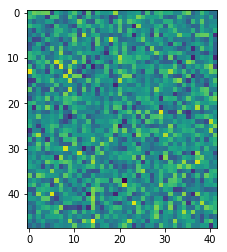

In [118]:
testout = (W@H)[:,1].reshape(yalebdims)
plt.imshow((testout / max(testout.reshape(-1))) * 255)

In [67]:
W2, H2, loss2 = factorize(bimages, niters=5000, rank=10, initial_matrices={'W':W1,'H':H1})

In [85]:
W3, H3, loss3 = factorize(bimages, niters=500, rank=10, initial_matrices={'W':W2,'H':H2})

/Users/njmd5/miniconda3/envs/dspy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/njmd5/miniconda3/envs/dspy/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


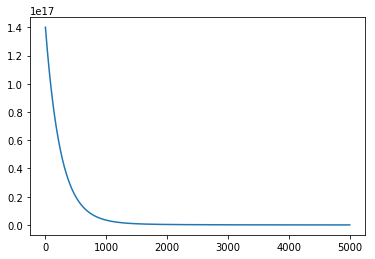

In [28]:
plt.plot(loss)

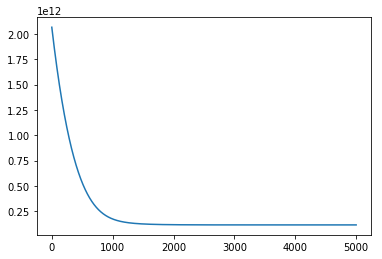

In [79]:
plt.plot(loss1)

In [ ]:
orldims = (int(112/REDUCE),int(92/REDUCE))
yalebdims = (int(192/REDUCE),int(168/REDUCE))

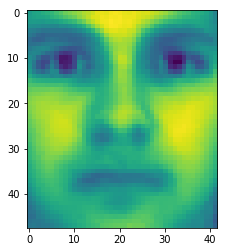

In [65]:
testout = (W1@H1)[:,1].reshape(yalebdims)
plt.imshow((testout / max(testout.reshape(-1))) * 255)

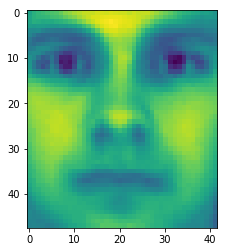

In [94]:
testout = (W2@H2)[:,100].reshape(yalebdims)
plt.imshow((testout / max(testout.reshape(-1))) * 255)

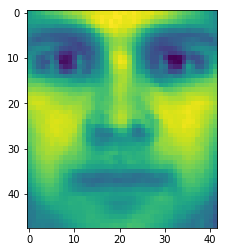

In [103]:
testout = (W2@H2)[:,2100].reshape(yalebdims)
plt.imshow((testout / max(testout.reshape(-1))) * 255)

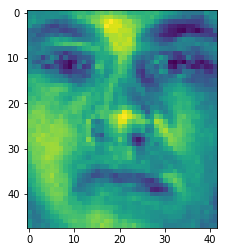

In [121]:
testout = (W2@H2)[:,2100].reshape(yalebdims) - (W2@H2)[:,10].reshape(yalebdims)
plt.imshow(testout)

In [122]:
(W2@H2)[:,2100].reshape(yalebdims)

array([[-52.84684174, -56.00724764, -57.71330585, ..., -54.08088728,
        -51.54037688, -47.18483363],
       [-52.48293552, -54.45117473, -55.75066458, ..., -54.69994383,
        -51.26129825, -48.03656968],
       [-52.44329987, -52.87561627, -53.36609348, ..., -52.95033465,
        -50.61781099, -48.00903402],
       ...,
       [-42.35005857, -42.96052223, -45.97189326, ..., -41.22563046,
        -40.05490275, -34.81763158],
       [-41.65051024, -43.07057504, -44.7605324 , ..., -40.84483713,
        -38.4470735 , -33.81798621],
       [-41.70635126, -43.61714447, -43.89076618, ..., -39.756338  ,
        -39.69301202, -35.07371025]])

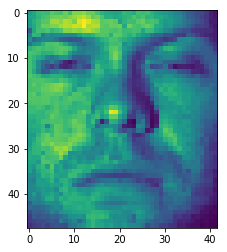

In [66]:
plt.imshow(images[:,1].reshape(yalebdims))